# BoomBikes Bike Sharing Linear Regression Assignment

In [3]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, warnings as wn
wn.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Data Reading

In [5]:
day = pd.read_csv('day.csv')

In [6]:
day

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,726,27-12-2019,1,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,247,1867,2114
726,727,28-12-2019,1,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,644,2451,3095
727,728,29-12-2019,1,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,159,1182,1341
728,729,30-12-2019,1,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,364,1432,1796


## Data Cleaning

#### Checking for null values in columns if any

In [9]:
day.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

#### Checking for single valued columns which will not be useful for regression

In [11]:
single_value_columns = day.columns[day.nunique() == 1]

In [12]:
single_value_columns

Index([], dtype='object')

#### Dropping duplicate values if any

In [14]:
day = day.drop_duplicates()

## Data Understanding

In [16]:
day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


#### We will have to drop few columns as they won't be significant in our analysis:
- 'instant' can be dropped as this just gives the serial number of data observations
- 'dteday' will not be required as we have 'yr', 'mnth', 'weekday' variables separately
- 'casual' and 'registered' are not of much use since we already have 'cnt', our target variable which is the total sum of both 'casual' and 'registered' count of rental bikes

In [18]:
day = day.drop(['instant','dteday','casual','registered'],axis=1)

In [19]:
day.shape

(730, 12)

In [20]:
day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


In [21]:
day.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,4508.006849
std,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,1936.011647
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,5966.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,8714.000000


#### Splitting the columns as Categorical and Numerical variables

In [23]:
categorical_var = ['season','yr','mnth','holiday','weekday','workingday','weathersit']
numerical_var = ['temp','atemp','hum','windspeed','cnt']

In [24]:
categorical_var_names = ['Season','Year','Month','Holiday','Day of Week','Working Day','Weather Type']
numerical_var_names = ['Temperature','Apparent Temperature','Humidity','Wind Speed','Count of Rental Bikes']
all_var_names = categorical_var_names + numerical_var_names

## Data Visualization

### Pairplot illustration of Numerical Variables

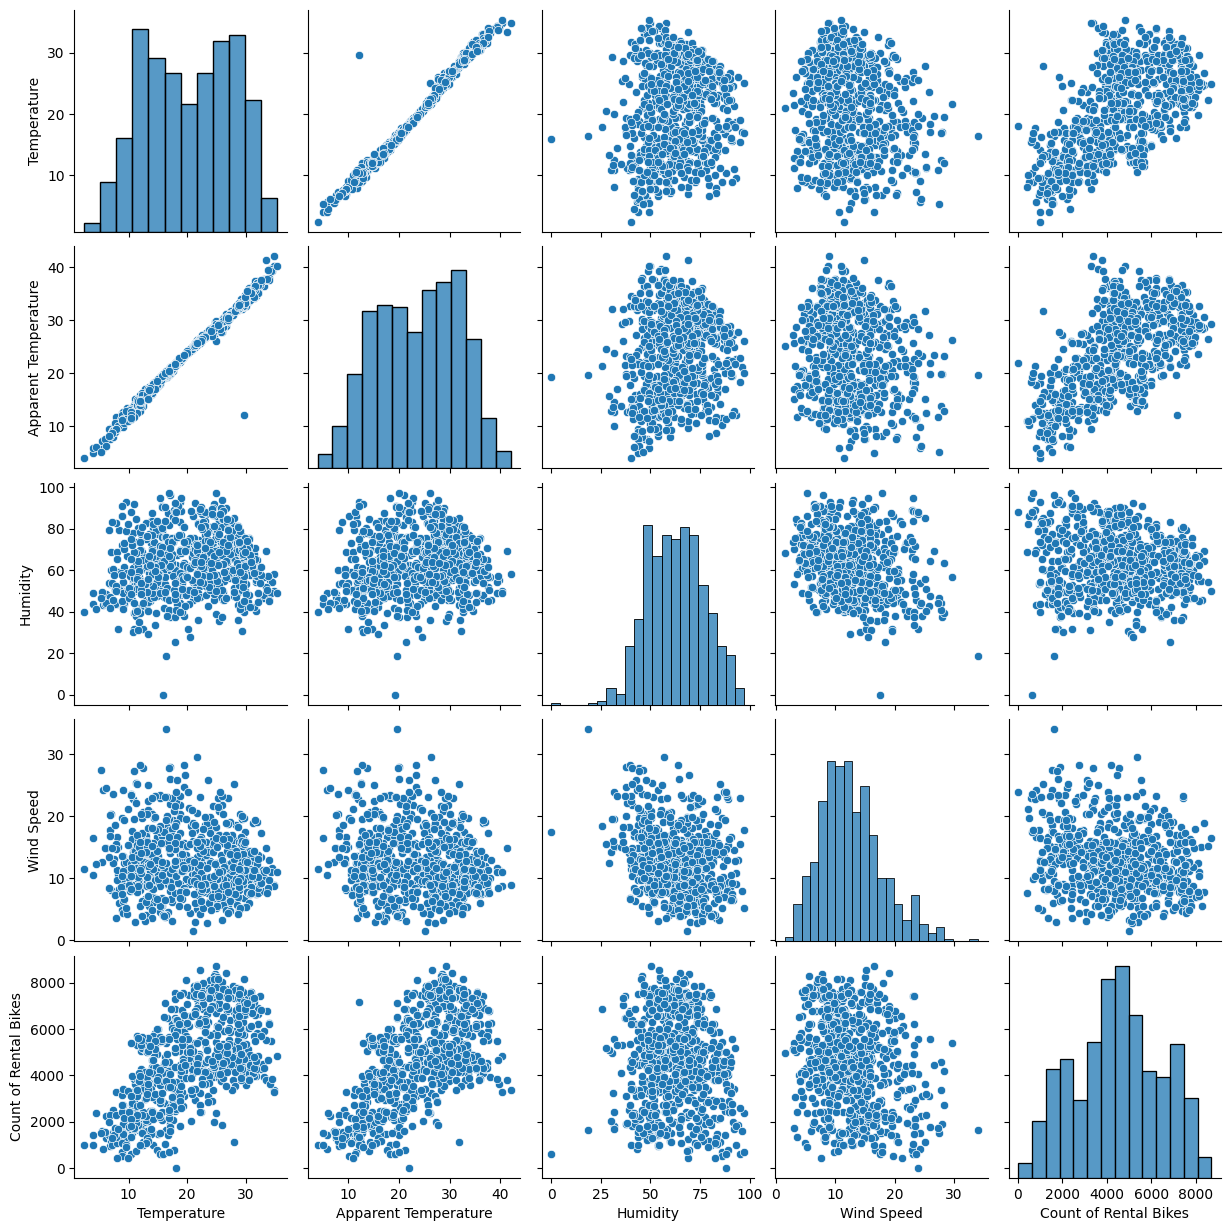

In [27]:
pairplot = sns.pairplot(data = day, vars = numerical_var)
for i in range(len(numerical_var)):
    for j in range(len(numerical_var)):
        pairplot.axes[i, j].set_xlabel(numerical_var_names[j])
        pairplot.axes[i, j].set_ylabel(numerical_var_names[i])
plt.show()

### Boxplot illustration of Categorical Variables

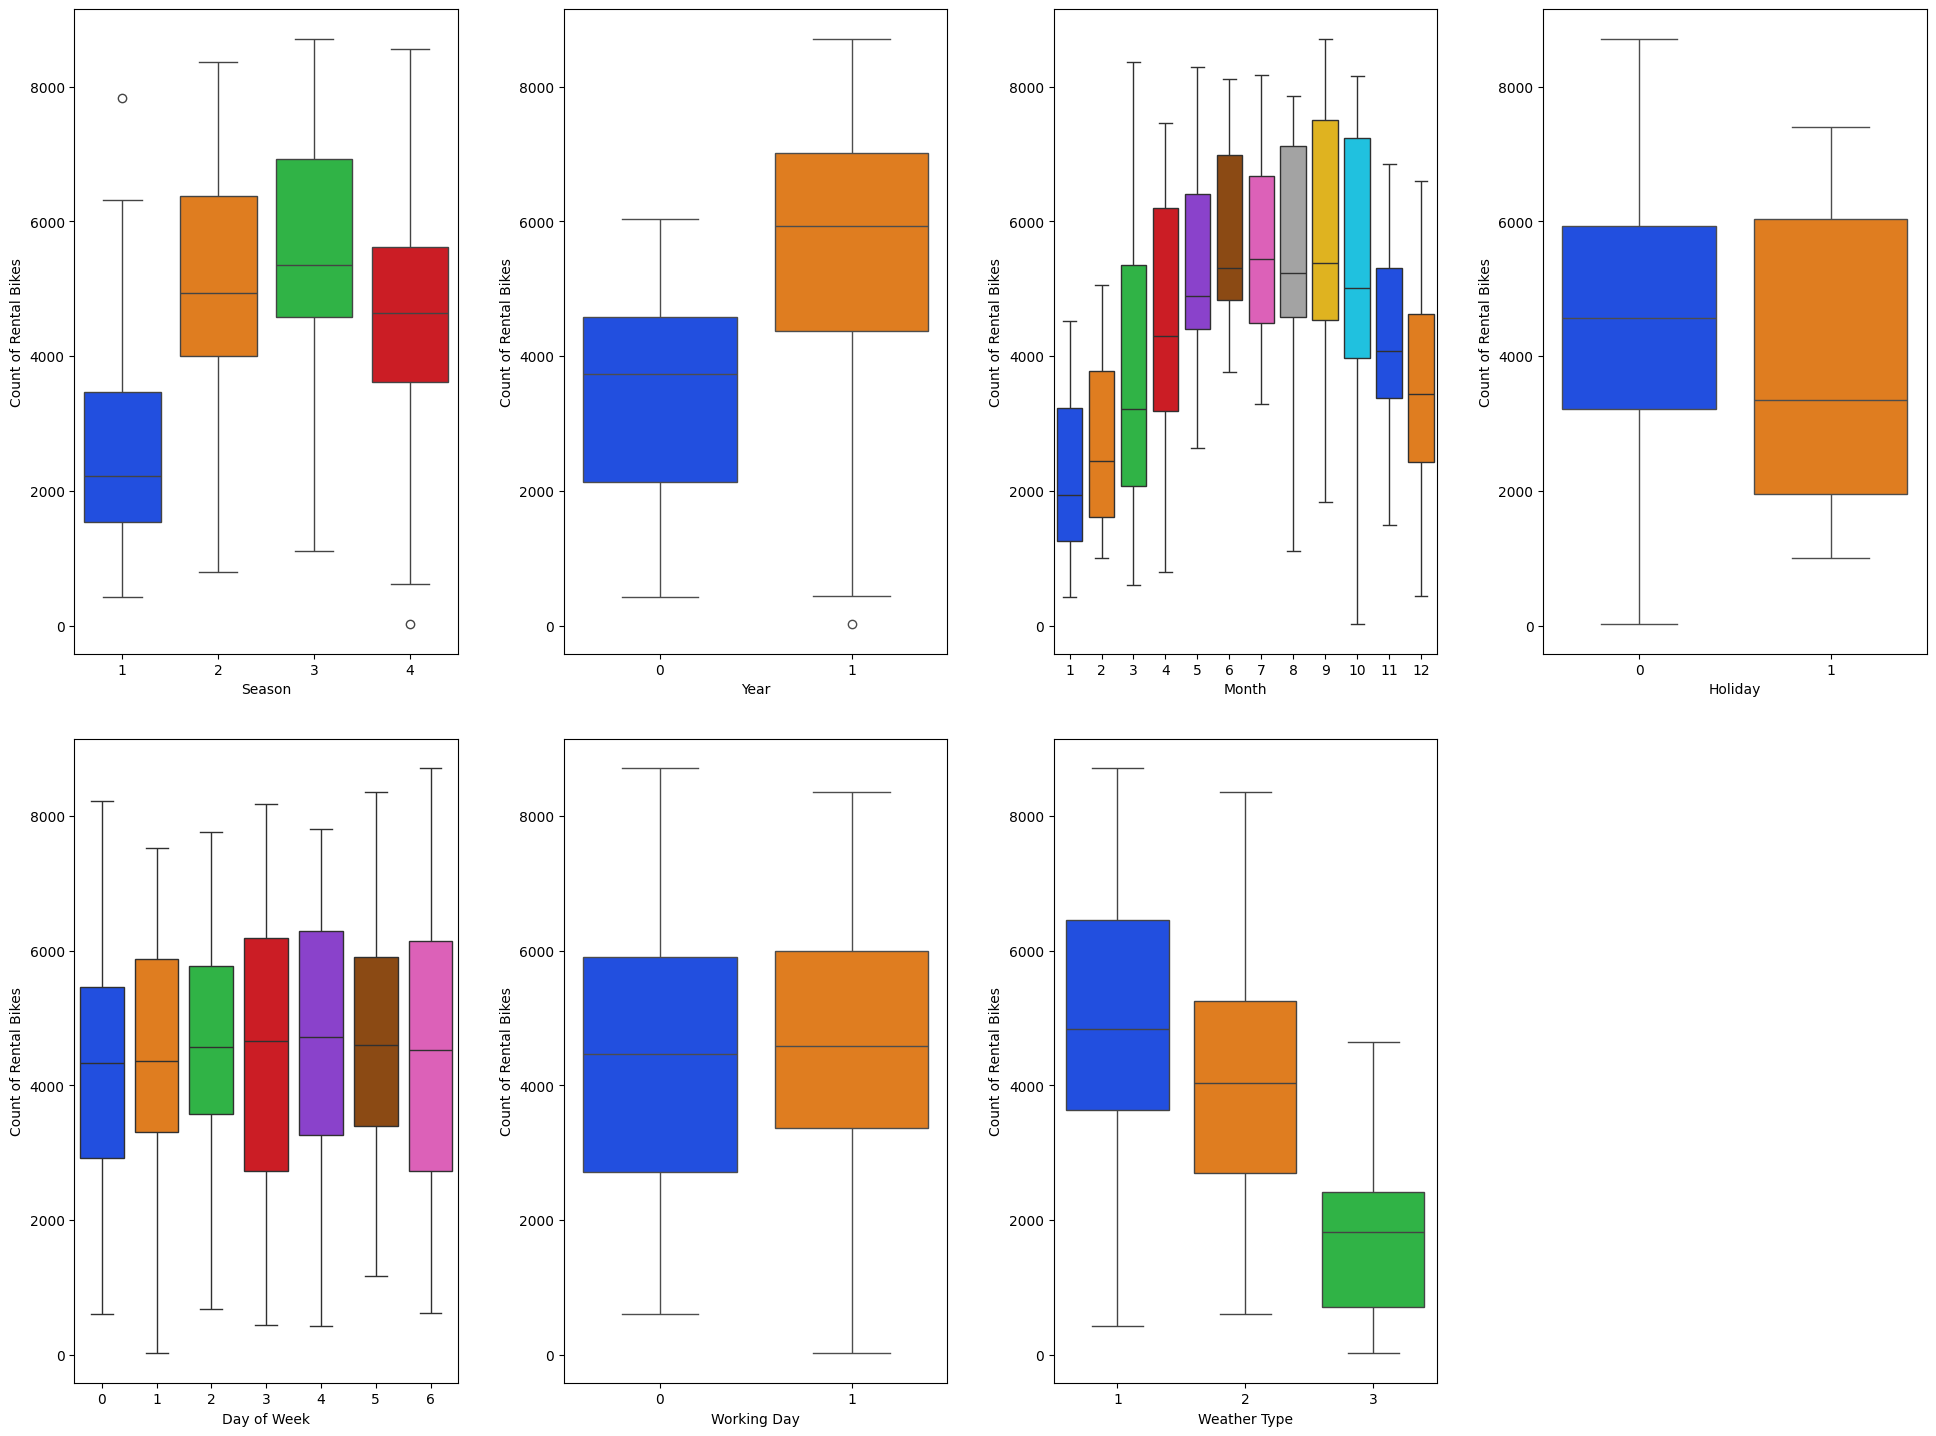

In [29]:
cat_len = len(categorical_var)
rows = (cat_len//2) - 1
cols = (cat_len//2) + 1
plt.figure(figsize=(20, 15))
for i in range(cat_len):
    plt.subplot(rows,cols,i+1)
    boxplot = sns.boxplot(data = day, x = categorical_var[i], y = 'cnt', palette = 'bright')
    boxplot.set_xlabel(categorical_var_names[i])
    boxplot.set_ylabel(numerical_var_names[-1])
plt.tight_layout(pad=3.0)
plt.show()

## Exploratory Data Analysis

### Univariate Analysis

#### Categorical Variables

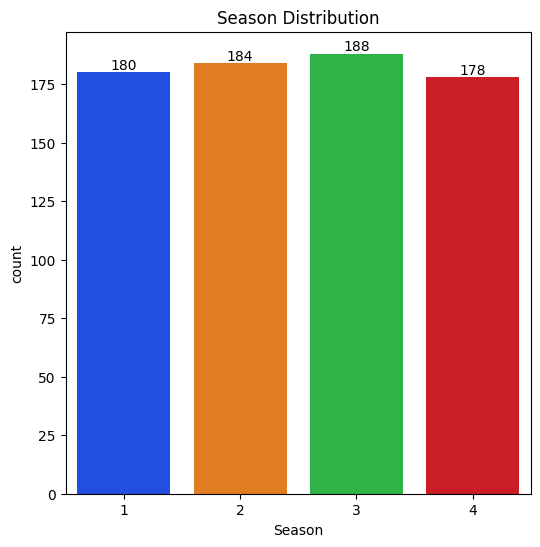

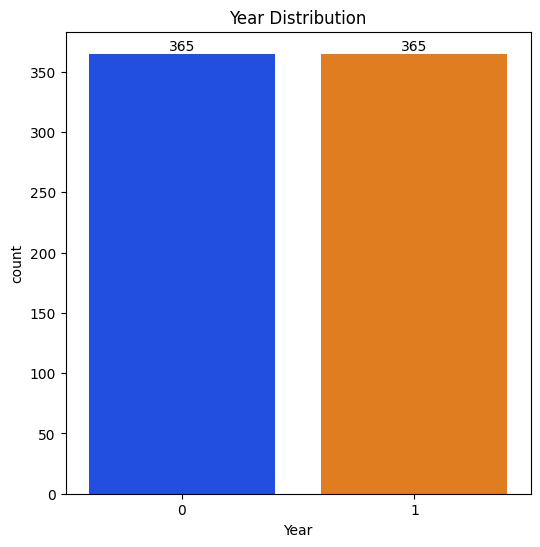

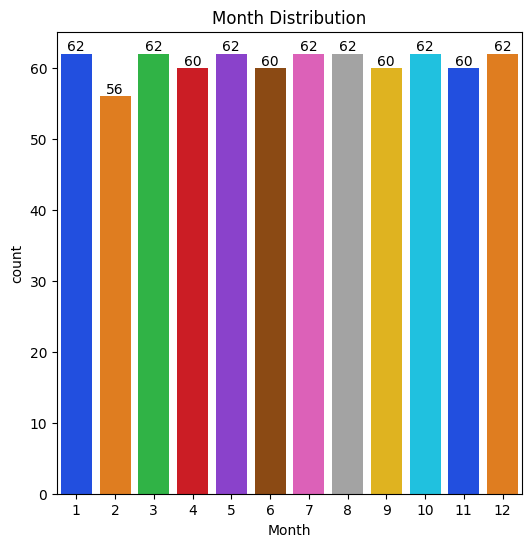

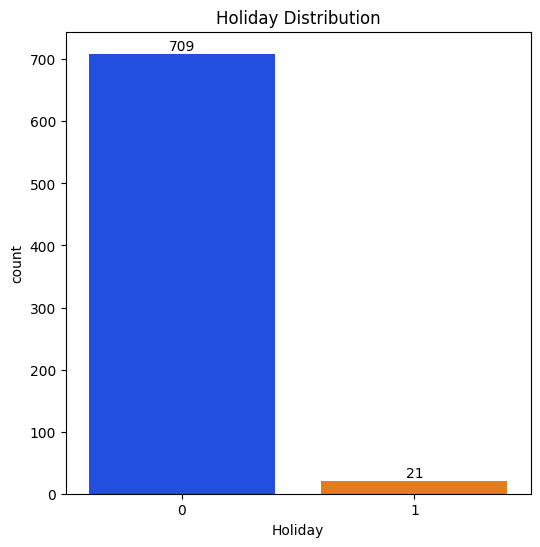

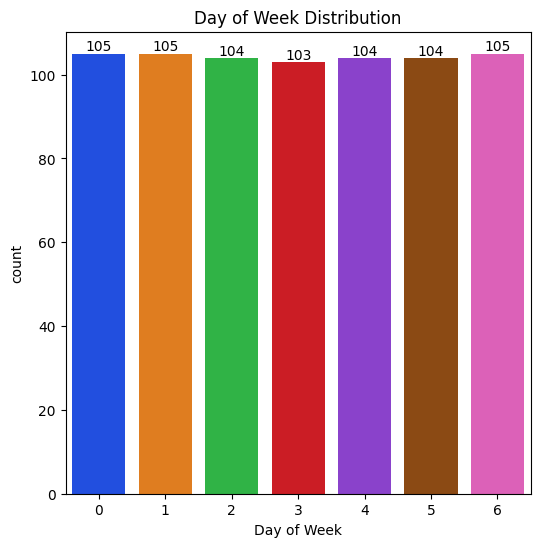

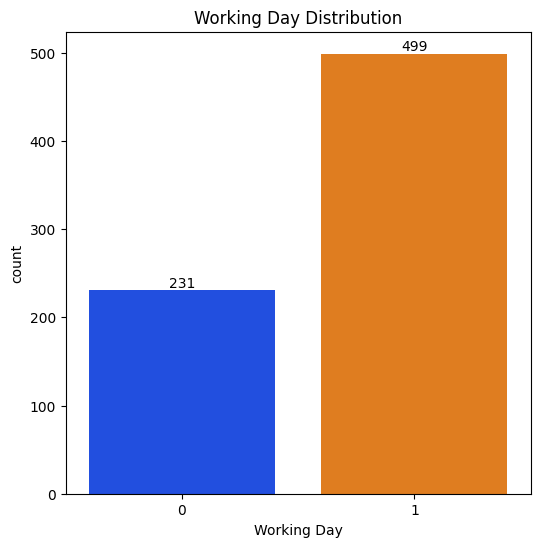

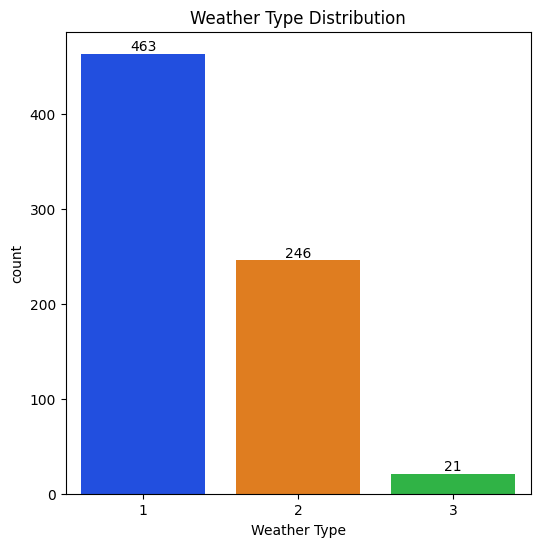

In [33]:
for i in range(len(categorical_var)):
    plt.figure(figsize=(6, 6))
    ax = sns.countplot(x=day[categorical_var[i]], palette='bright')
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
        (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', va='bottom')
    plt.title(categorical_var_names[i] + ' Distribution')
    plt.xlabel(categorical_var_names[i])
    plt.show()

#### Numerical Variables

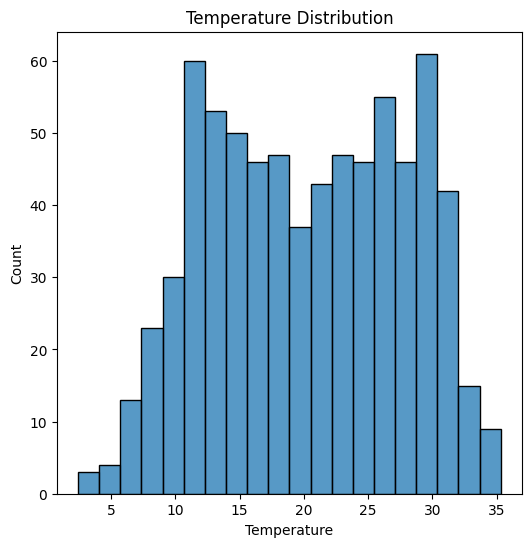

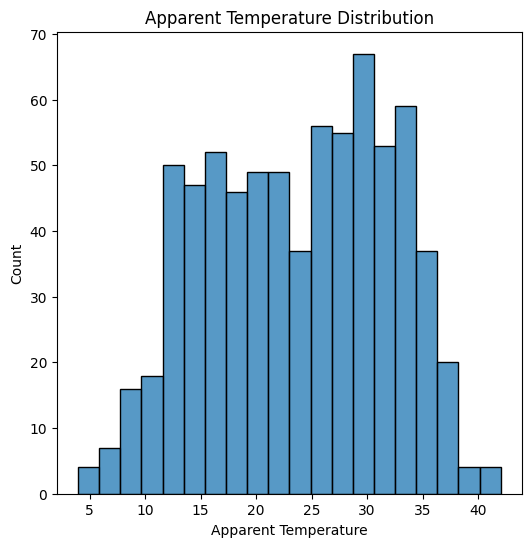

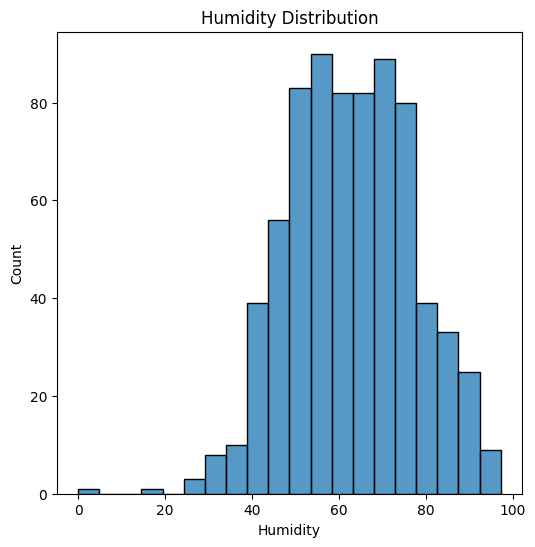

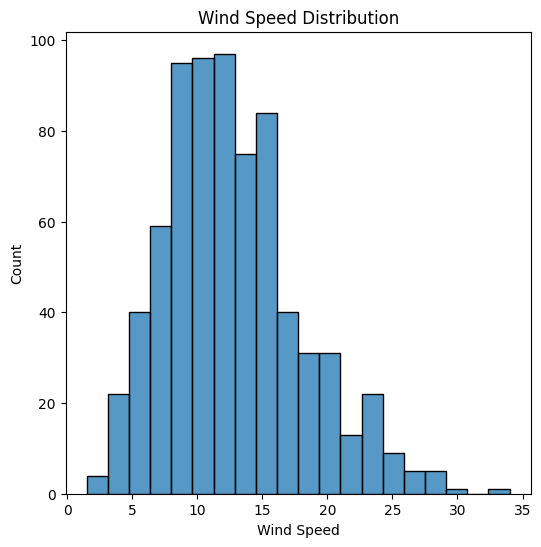

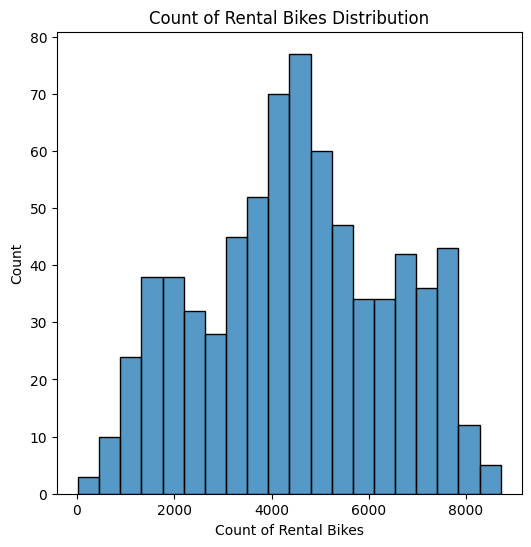

In [35]:
for i in range(len(numerical_var)):
    plt.figure(figsize=(6, 6))
    sns.histplot(x=day[numerical_var[i]], bins=20)
    plt.title(numerical_var_names[i] + ' Distribution')
    plt.xlabel(numerical_var_names[i])
    plt.show()

#### Results of Univariate Analysis

##### Categorical Variables:
 - There are 4 seasons having almost equal count of observations with 'Autumn' being longest season
 - There are 2 years with same count of observations equal to number of days in an year
 - There are 12 months with the count of observations equal to number of days in every month for 2 years correspondingly
 - There are 21 holidays in the 2 years period
 - There are 7 days with the count of observations equal to number of days in every week for 2 years correspondingly
 - There are 499 business working days and 231 weekend days
 - There are 3 weather types with Clear weather being the highest recorded weather type and Light Rain Weather being the least recorded weather type

##### Numerical Variables:
 - Temperature of 10-12 °C and 28-30 °C have been the most recorded range of temperature
 - Apparent Temperature of 28-30 °C has been the most feels-like temperature range in given data
 - Humidity of the range 50-80 % is most recorded humidity in a day
 - Wind speed between 7.5-12.5 m/s is the most recorded wind speed during a day
 - Rental Bikes Count between 4000-5000 is the most recorded total bikes count per day

### Bivariate Analysis

We shall consider performing Bivariate Analysis with respect to Count of Rental Bikes only.

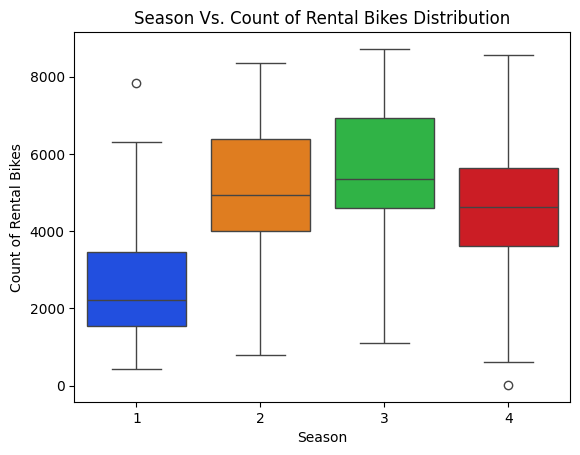

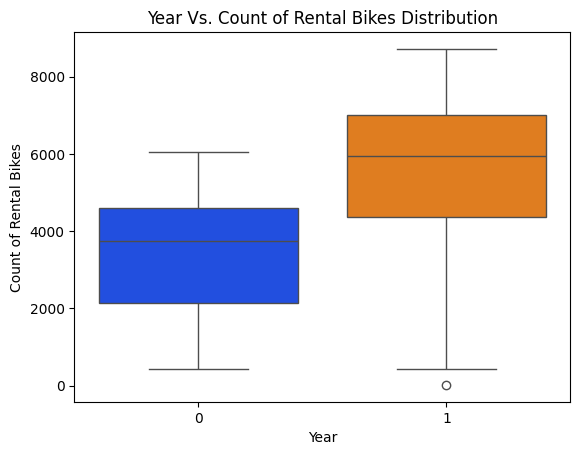

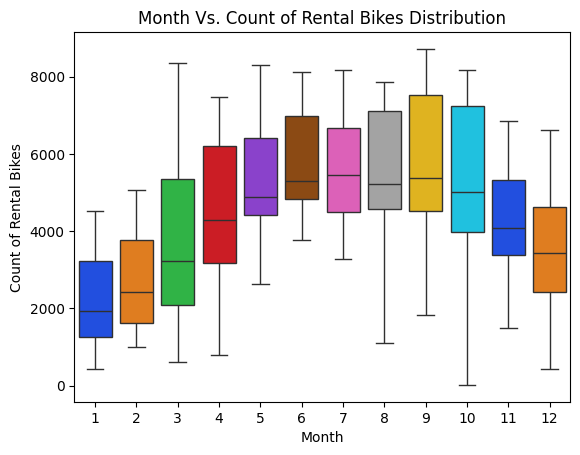

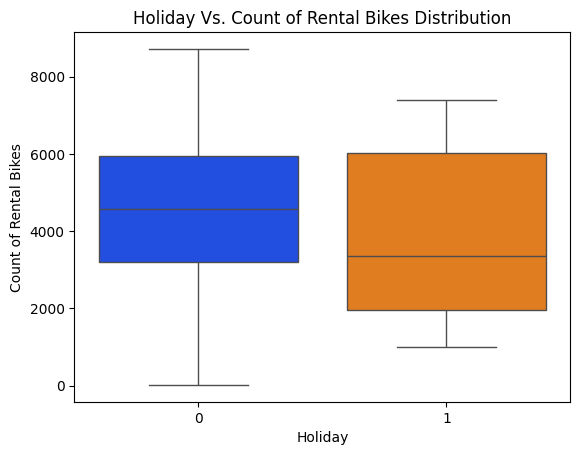

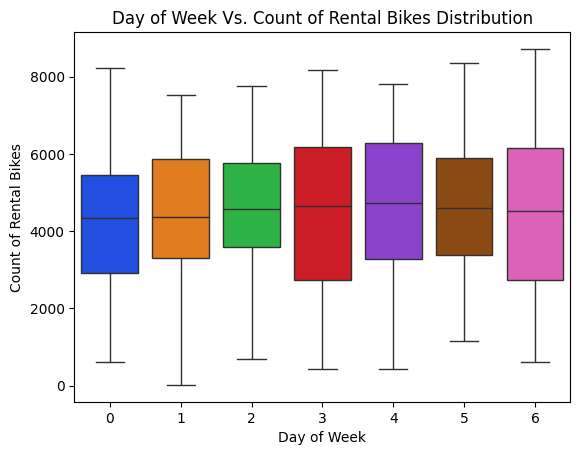

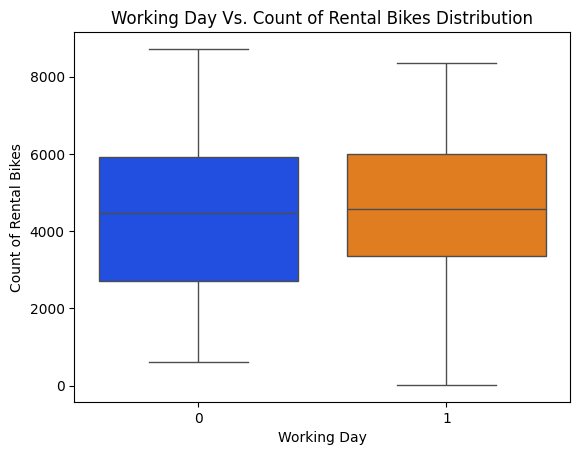

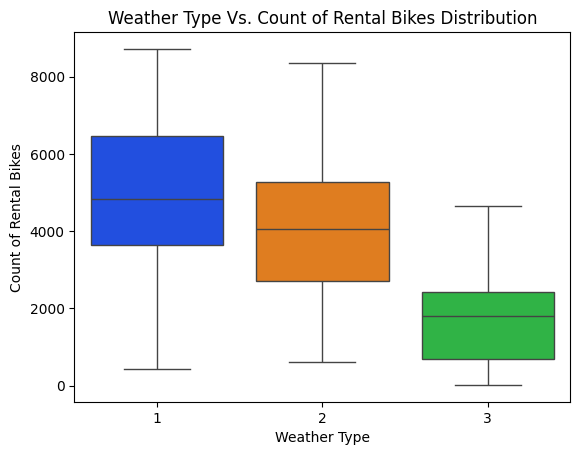

In [39]:
cat_len = len(categorical_var)
rows = (cat_len//2) - 1
cols = (cat_len//2) + 1
for i in range(cat_len):
    boxplot = sns.boxplot(data = day, x = categorical_var[i], y = 'cnt', palette = 'bright')
    plt.title(categorical_var_names[i] + ' Vs. ' + numerical_var_names[-1] + ' Distribution')
    boxplot.set_xlabel(categorical_var_names[i])
    boxplot.set_ylabel(numerical_var_names[-1])
    plt.show()

For analyzing Count of Rental Bikes with numerical variables, we'll split the bikes count into batches:

In [41]:
cnt_batch = pd.cut(day['cnt'], bins=9, labels=['0-1k','1k-2k','2k-3k','3k-4k','4k-5k','5k-6k','6k-7k','7k-8k','8k-9k'])

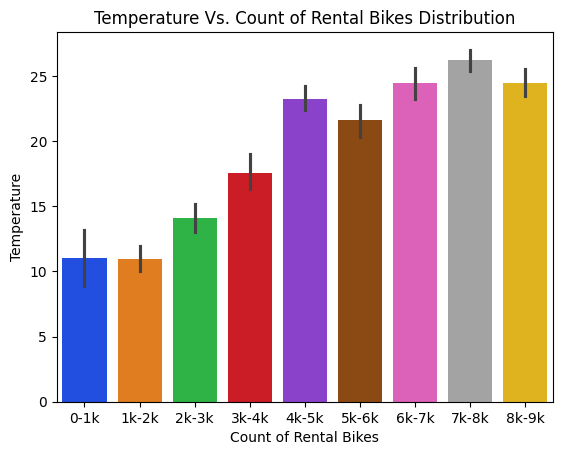

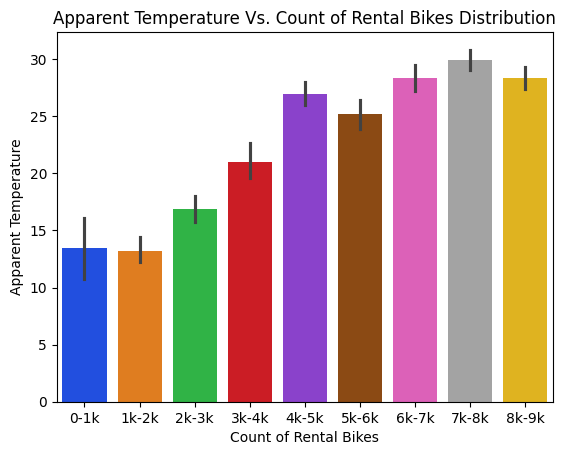

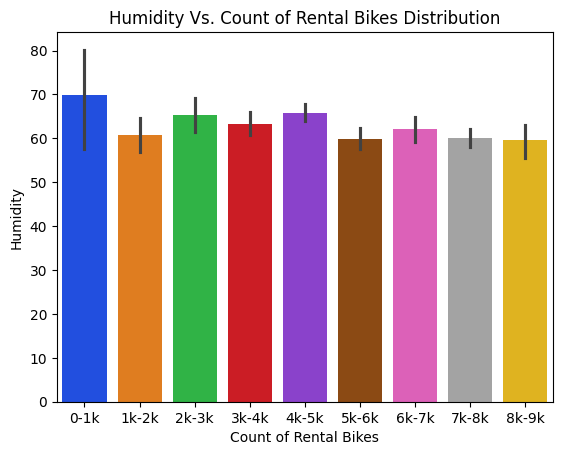

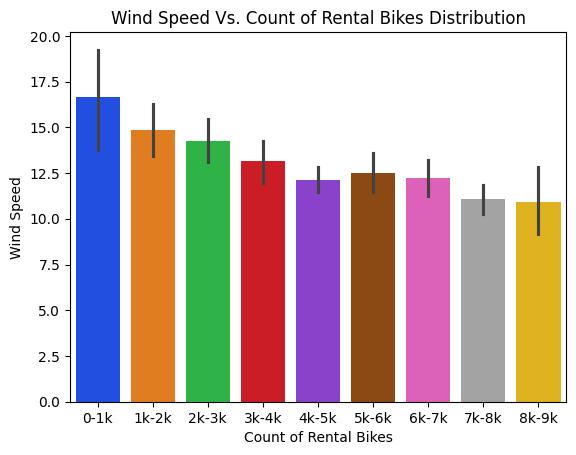

In [42]:
for i in range(len(numerical_var)-1):
    sns.barplot(x=cnt_batch, y=day[numerical_var[i]], palette='bright')
    plt.title(numerical_var_names[i] + ' Vs. ' + numerical_var_names[-1] + ' Distribution')
    plt.xlabel(numerical_var_names[-1])
    plt.ylabel(numerical_var_names[i])
    plt.show()

#### Results of Bivariate Analysis
##### Categorical Variables Vs. Count of Rental Bikes
 - The bikes count rented was the most during Fall season followed by Summer season.
 - The demand for rental bikes has increased a lot from 2018 to 2019.
 - July month was pretty good with high median of bikes count and September witnessed the maximum count of rental bikes
 - Bikes were rented lesser in number during holidays
 - The rented bikes count followed similar pattern for all 7 days in a week
 - The bikes were slightly on higher demand during business working days
 - The bikes were rented the maximum at the times of Clear weather. The count was very low when it is Light Rain weather.

##### Numerical Variables Vs. Count of Rental Bikes
 - Around 6000-8000 bikes were rented when temperature is more than 25 °C. Increase in temperature leads to increase in bikes demand.
 - Around 7000-8000 bikes were rented when apparent temperature is more than 25 °C. Increase in apparent temperature also follows similar relation as temperature.
 - Less than 1000 bikes were rented when humidity is more than 70 %. The demand for bikes almost seems similar for any humidity less than 65 %.
 - Less than 3000 bikes were rented when wind speed is greater than 15 m/s. High wind speed is unfavorable for bikes rental.

### Multivariate Analysis

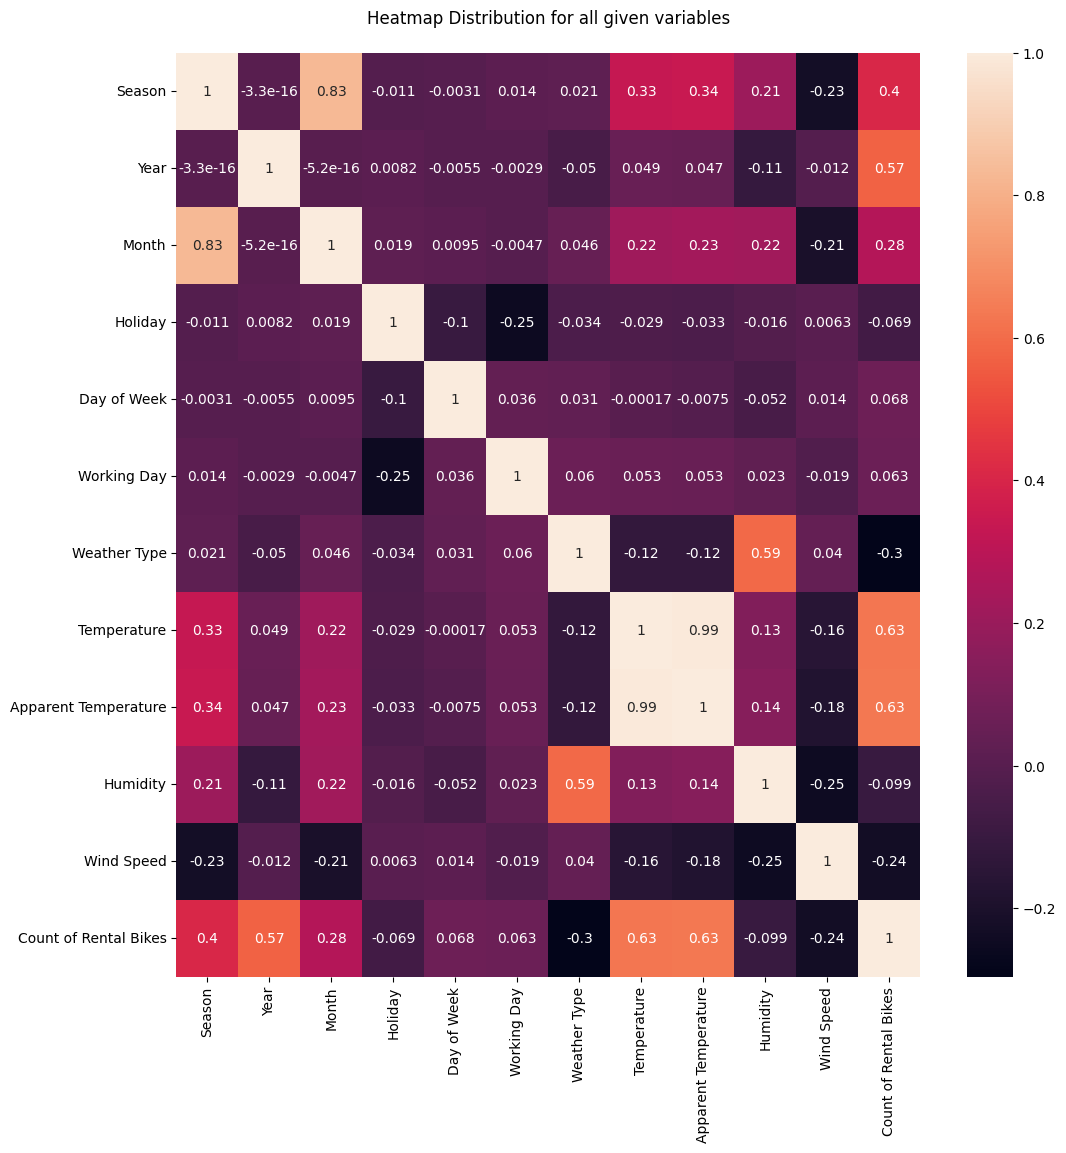

In [45]:
plt.figure(figsize=(12,12))
heatmap = sns.heatmap(day.corr(), annot=True, cmap='rocket')
plt.title('Heatmap Distribution for all given variables\n')
heatmap.set_xticklabels((i for i in all_var_names), rotation=90)
heatmap.set_yticklabels((i for i in all_var_names), rotation=0)
plt.show()

#### Results of Multivariate Analysis
 - Temperature and Apparent Temperature have very high correlation as they indicate the same feature.
 - Count of rental bikes has high positive correlation with Season, Year, Temperature and Apparent Temperature. These variables impact the demand hugely and positively.
 - Count of rental bikes has relatively low impact from humidity, month, working days, weekdays and holidays.
 - Humidity has high positive correlation with weather type as it is low during Clear weather and high during Rainy weather.
 - Season has good correlation with month, as the season changes with change in months
 - The demand for rental bikes decreases with high wind speed and weather type shifting from Clear Skies to Rainy weather.

## Data Preparation

### Create Dummy Variables for Categorical Variables

#### Now we'll have to create dummy variables for each categorical variable which can have more than 2 values

In [50]:
categorical_var

['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

- #### Season (season): 

It indicates 4 values of Season: 'Spring', 'Summer', 'Autumn' and 'Winter' in the same order respectively

In [53]:
sorted(day['season'].unique())

[1, 2, 3, 4]

Generating Dummies for 'season' variable and dropping the first variable which is for Spring Season (1):

In [55]:
season_dummies = pd.get_dummies(day['season'], drop_first=True, dtype = int)

In [56]:
season_dummies.sample(10)

,2,3,4
465,1,0,0
404,0,0,0
691,0,0,1
409,0,0,0
316,0,0,1
224,0,1,0
157,1,0,0
192,0,1,0
713,0,0,1
399,0,0,0


Renaming new dummy variables of 'season'

In [58]:
season_dummies_names = season_dummies.rename(columns={2:'summerSeason', 3:'fallSeason', 4:'winterSeason'})

In [59]:
season_dummies_names.sample(10)

,summerSeason,fallSeason,winterSeason
418,0,0,0
152,1,0,0
662,0,0,1
658,0,0,1
336,0,0,1
64,0,0,0
504,1,0,0
503,1,0,0
556,0,1,0
294,0,0,1


Concatenating dummy variables of 'season' to 'day' dataframe

In [61]:
day = pd.concat((day,season_dummies_names),axis=1)

- #### Year (yr):

It indicates 0 for year 2018 and 1 for year 2019

In [64]:
sorted(day['yr'].unique())

[0, 1]

No need to generate dummy variable since 'yr' has only 2 values: 0 and 1

- #### Month (mnth):

It indicates 12 months in an year: 'January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November' and 'December' in the same order respectively

In [68]:
sorted(day['mnth'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Generating Dummies for 'mnth' variable and dropping the first variable which is for January month (1):

In [70]:
month_dummies = pd.get_dummies(day['mnth'], drop_first=True, dtype = int)

In [71]:
month_dummies.sample(10)

,2,3,4,5,6,7,8,9,10,11,12
259,0,0,0,0,0,0,0,1,0,0,0
108,0,0,1,0,0,0,0,0,0,0,0
227,0,0,0,0,0,0,1,0,0,0,0
379,0,0,0,0,0,0,0,0,0,0,0
292,0,0,0,0,0,0,0,0,1,0,0
195,0,0,0,0,0,1,0,0,0,0,0
364,0,0,0,0,0,0,0,0,0,0,1
668,0,0,0,0,0,0,0,0,1,0,0
451,0,1,0,0,0,0,0,0,0,0,0
619,0,0,0,0,0,0,0,1,0,0,0


Renaming new dummy variables of 'mnth'

In [73]:
month_dummies_names = month_dummies.rename(columns={2:'feb', 3:'mar', 4:'apr', 5:'may', 6:'jun', 7:'jul',
                                                    8:'aug', 9:'sep', 10:'oct', 11:'nov', 12:'dec'})

In [74]:
month_dummies_names.sample(10)

,feb,mar,apr,may,jun,jul,aug,sep,oct,nov,dec
399,1,0,0,0,0,0,0,0,0,0,0
78,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0
95,0,0,1,0,0,0,0,0,0,0,0
55,1,0,0,0,0,0,0,0,0,0,0
578,0,0,0,0,0,0,1,0,0,0,0
303,0,0,0,0,0,0,0,0,1,0,0
493,0,0,0,1,0,0,0,0,0,0,0
560,0,0,0,0,0,1,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,0


Concatenating dummy variables of 'mnth' to 'day' dataframe

In [76]:
day = pd.concat((day,month_dummies_names),axis=1)

- #### Holiday (holiday):

It indicates 0 for Usual Business day and 1 for Holiday

In [79]:
sorted(day['holiday'].unique())

[0, 1]

No need to generate dummy variable since 'holiday' has only 2 values: 0 and 1

- #### Weekday (weekday):

It indicates 7 days in a week: 'Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday' and 'Saturday' in the same order respectively

In [83]:
sorted(day['weekday'].unique())

[0, 1, 2, 3, 4, 5, 6]

Generating Dummies for 'weekday' variable and dropping the first variable which is for Sunday (0):

In [85]:
weekday_dummies = pd.get_dummies(day['weekday'], drop_first=True, dtype = int)

In [86]:
weekday_dummies.sample(10)

,1,2,3,4,5,6
446,0,0,0,0,1,0
454,0,0,0,0,0,1
26,0,0,0,1,0,0
172,0,0,1,0,0,0
572,0,0,0,0,1,0
272,0,0,0,0,1,0
624,1,0,0,0,0,0
262,0,1,0,0,0,0
343,0,0,0,0,0,1
410,0,0,1,0,0,0


Renaming new dummy variables of 'weekday'

In [88]:
weekday_dummies_names = weekday_dummies.rename(columns={1:'mon', 2:'tue', 3:'wed', 4:'thu', 5:'fri', 6:'sat'})

In [89]:
weekday_dummies_names.sample(10)

,mon,tue,wed,thu,fri,sat
278,0,0,0,1,0,0
687,1,0,0,0,0,0
442,1,0,0,0,0,0
412,0,0,0,0,1,0
691,0,0,0,0,1,0
432,0,0,0,0,1,0
88,0,0,1,0,0,0
316,0,0,0,0,0,0
331,1,0,0,0,0,0
389,0,0,1,0,0,0


Concatenating dummy variables of 'weekday' to 'day' dataframe

In [91]:
day = pd.concat((day,weekday_dummies_names),axis=1)

- #### Working Day (workingday):

It indicates 0 for Weekend and 1 for Working Day in a week irrespective of holidays

In [94]:
sorted(day['workingday'].unique())

[0, 1]

No need to generate dummy variable since 'workingday' has only 2 values: 0 and 1

- #### Weather Type (weathersit):

In [97]:
sorted(day['weathersit'].unique())

[1, 2, 3]

Generating Dummies for 'weathersit' variable and dropping the first variable which is for Clear Weather type (0):

In [99]:
weathersit_dummies = pd.get_dummies(day['weathersit'], drop_first=True, dtype=int)

In [100]:
weathersit_dummies.sample(10)

,2,3
213,0,0
376,1,0
489,1,0
665,1,0
322,0,0
303,0,0
722,1,0
39,1,0
459,0,0
128,0,0


Renaming new dummy variables of 'weathersit'

In [102]:
weathersit_dummies_names = weathersit_dummies.rename(columns={2:'mistWeather', 3:'lightRainWeather', 4:'heavyRainWeather'})

In [103]:
weathersit_dummies_names.sample(10)

,mistWeather,lightRainWeather
143,1,0
635,1,0
441,1,0
222,0,0
107,0,0
362,0,0
675,1,0
508,0,0
243,0,0
343,0,0


Concatenating dummy variables of 'weekday' to 'day' dataframe

In [105]:
day = pd.concat((day,weathersit_dummies_names),axis=1)

### Removing Original Categorical Variables for which Dummy Variables were added

Dropping the 4 original variables of which dummy variables were added: 'season', 'mnth', 'weekday' and 'weathersit'

In [108]:
day = day.drop(['season','mnth','weekday','weathersit'], axis=1)

In [109]:
day.sample(10)

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,summerSeason,fallSeason,...,nov,dec,mon,tue,wed,thu,fri,sat,mistWeather,lightRainWeather
90,0,0,1,12.300000,14.17270,68.6250,17.333436,2227,1,0,...,0,0,0,0,0,0,1,0,1,0
571,1,0,1,31.843347,36.96315,59.6667,19.082471,6861,0,1,...,0,0,0,0,0,1,0,0,0,0
612,1,0,1,30.203347,35.44915,74.1250,12.583136,7112,0,1,...,0,0,0,0,1,0,0,0,0,0
352,0,0,1,11.343347,14.04665,63.7500,11.584032,3403,0,0,...,0,1,1,0,0,0,0,0,0,0
64,0,0,0,15.437402,18.31260,94.8261,23.000229,605,0,0,...,0,0,0,0,0,0,0,0,1,0
435,1,0,1,19.133347,22.97960,48.9167,13.916771,5298,0,0,...,0,0,1,0,0,0,0,0,0,0
72,0,0,1,13.333897,16.60000,49.6957,9.174042,2046,0,0,...,0,0,1,0,0,0,0,0,0,0
486,1,0,1,23.130847,26.89480,79.7083,9.249886,6169,1,0,...,0,0,0,0,1,0,0,0,0,0
182,0,0,0,30.271653,33.36540,44.4583,7.709154,5119,0,1,...,0,0,0,0,0,0,0,1,0,0
199,0,0,1,31.843347,37.37395,65.0417,8.750200,4541,0,1,...,0,0,0,1,0,0,0,0,0,0


New dimensions of 'day' dataframe:

In [111]:
day.shape

(730, 30)

In [112]:
day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   yr                730 non-null    int64  
 1   holiday           730 non-null    int64  
 2   workingday        730 non-null    int64  
 3   temp              730 non-null    float64
 4   atemp             730 non-null    float64
 5   hum               730 non-null    float64
 6   windspeed         730 non-null    float64
 7   cnt               730 non-null    int64  
 8   summerSeason      730 non-null    int32  
 9   fallSeason        730 non-null    int32  
 10  winterSeason      730 non-null    int32  
 11  feb               730 non-null    int32  
 12  mar               730 non-null    int32  
 13  apr               730 non-null    int32  
 14  may               730 non-null    int32  
 15  jun               730 non-null    int32  
 16  jul               730 non-null    int32  
 1

## Linear Regression Model Development

### Data Preprocessing

#### Train - Test Data Splitting:

For our regression analysis, we'll be splitting the data into 70% and 30% for Model Training and Testing respectively:

In [117]:
day_train, day_test = train_test_split(day, train_size = 0.7, random_state = 100)

Dimensions of Train and Test Data:

In [119]:
print(day_train.shape)
print(day_test.shape)

(510, 30)
(220, 30)


#### Scaling the Variables:

Linear Regression performed on 1 independent variable is called Simple Linear Regression. Our dataset indicates that there are multiple independent variables where each variable impacts our target variable in its own way. So we need to perform Multiple Linear Regression for which, we need to scale all the independent feature variables into a single format, as each variable has different magnitude in their values range due to different units. We have 2 major methods of feature scaling:
1. Min-Max Scaling
2. Standardization Scaling

For this model development, we'll be following Min-Max Scaling which is widely used. We'll apply fit and transform of training data to convert into a Min-Max normalized data.

In [122]:
scaler = MinMaxScaler()
day_train[numerical_var] = scaler.fit_transform(day_train[numerical_var])

In [123]:
day_train.sample(10)

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,summerSeason,fallSeason,...,nov,dec,mon,tue,wed,thu,fri,sat,mistWeather,lightRainWeather
565,1,0,1,0.755981,0.700889,0.869901,0.358292,0.672803,0,1,...,0,0,0,0,0,0,1,0,1,0
688,1,0,1,0.392551,0.395887,0.705882,0.086897,0.645651,0,0,...,1,0,0,1,0,0,0,0,1,0
237,0,0,1,0.798555,0.762199,0.784457,0.089557,0.533709,0,1,...,0,0,0,0,0,0,1,0,0,0
61,0,0,1,0.173453,0.158912,0.328037,0.394381,0.191325,0,0,...,0,0,0,0,0,1,0,0,0,0
597,1,0,1,0.735215,0.685137,0.694289,0.065497,0.803497,0,1,...,0,0,0,1,0,0,0,0,0,0
77,0,0,0,0.515079,0.508588,0.390726,0.700541,0.356075,0,0,...,0,0,0,0,0,0,0,1,0,0
618,1,0,1,0.645914,0.623794,0.535852,0.106953,0.891049,0,1,...,0,0,0,1,0,0,0,0,0,0
27,0,0,1,0.179864,0.189344,0.817219,0.174125,0.131730,0,0,...,0,0,0,0,0,0,1,0,1,0
112,0,0,0,0.499503,0.487055,0.914985,0.405068,0.461804,1,0,...,0,0,0,0,0,0,0,1,1,0
317,0,0,1,0.586727,0.584835,0.604980,0.568175,0.513576,0,0,...,1,0,1,0,0,0,0,0,0,0


All the variables have been normalized with minimum value of 0 and maximum value of 1 including target variable

In [125]:
day_train.describe().T

,count,mean,std,min,25%,50%,75%,max
yr,510.0,0.507843,0.500429,0.0,0.000000,1.000000,1.000000,1.0
holiday,510.0,0.025490,0.157763,0.0,0.000000,0.000000,0.000000,1.0
workingday,510.0,0.676471,0.468282,0.0,0.000000,1.000000,1.000000,1.0
temp,510.0,0.537440,0.225858,0.0,0.339853,0.542596,0.735215,1.0
atemp,510.0,0.513156,0.212410,0.0,0.332086,0.529718,0.688457,1.0
hum,510.0,0.650480,0.145846,0.0,0.538643,0.653714,0.754830,1.0
windspeed,510.0,0.320883,0.169803,0.0,0.199179,0.296763,0.414447,1.0
cnt,510.0,0.513499,0.224421,0.0,0.356420,0.518638,0.684710,1.0
summerSeason,510.0,0.247059,0.431725,0.0,0.000000,0.000000,0.000000,1.0
fallSeason,510.0,0.262745,0.440557,0.0,0.000000,0.000000,1.000000,1.0


Heatmap indicating the correlations of all the variables including dummy variables:

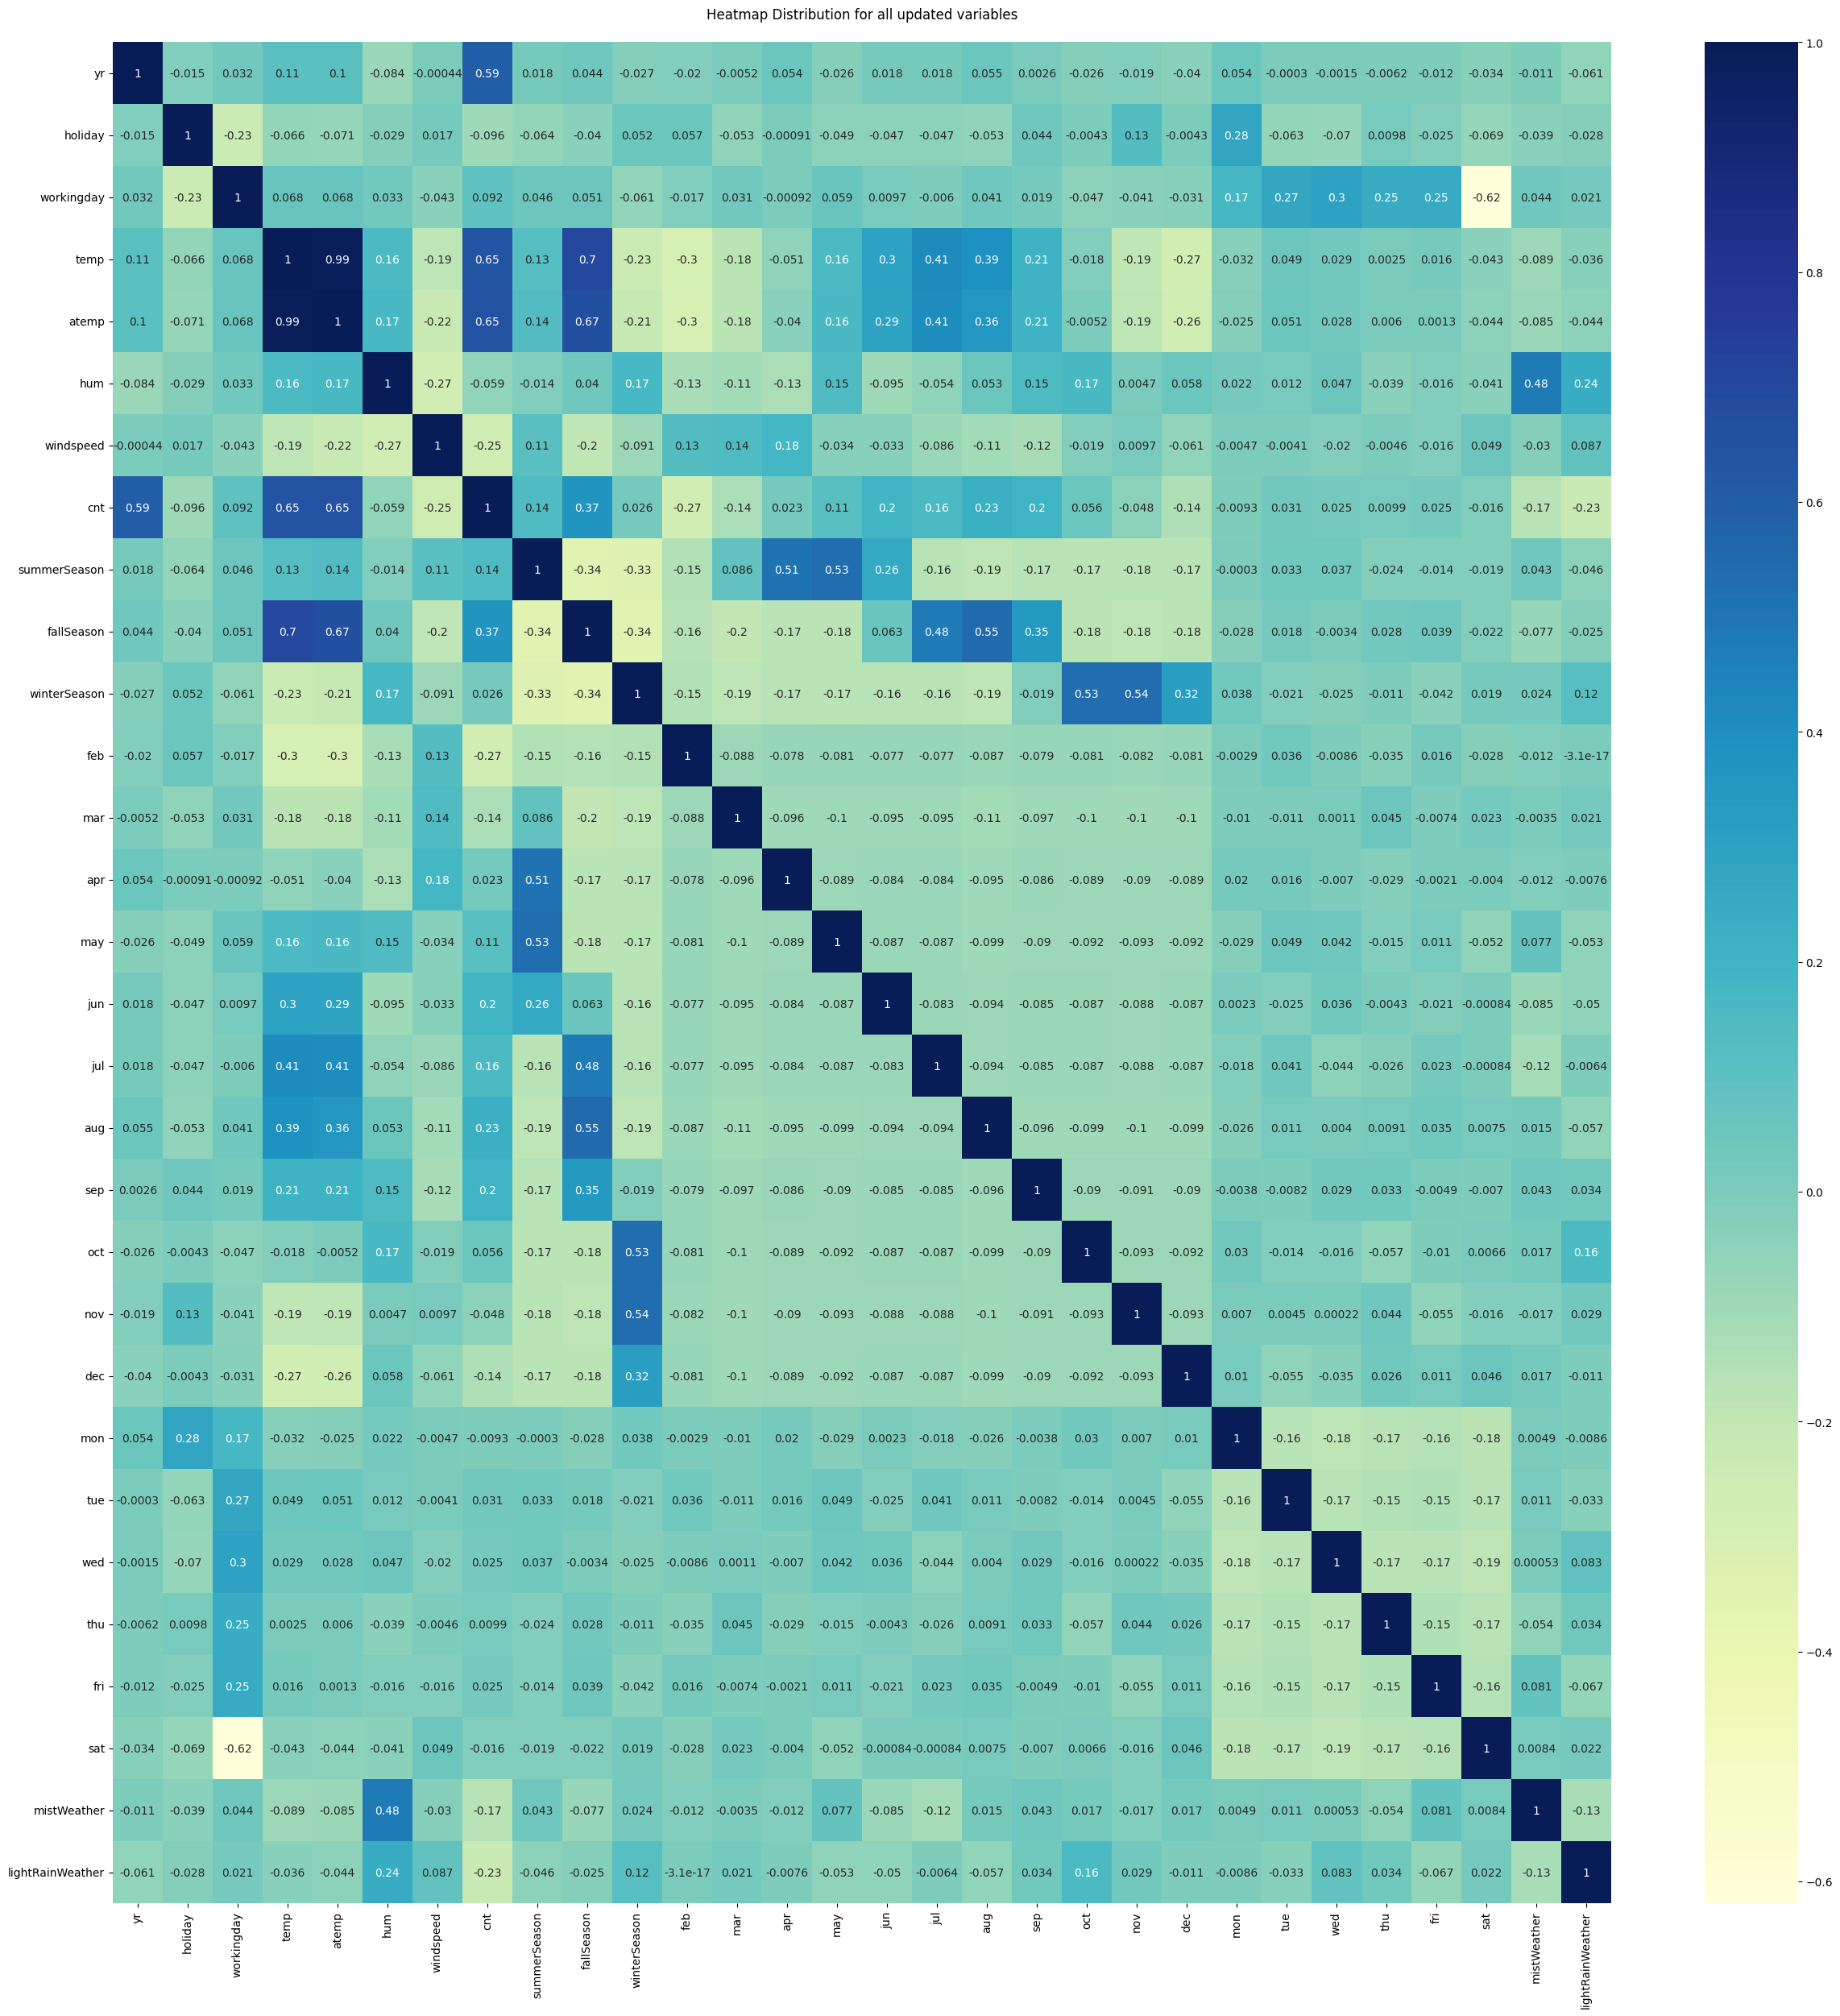

In [127]:
plt.figure(figsize=(30,30))
sns.heatmap(day_train.corr(), annot=True, cmap='YlGnBu')
plt.title('Heatmap Distribution for all updated variables\n')
plt.show()

Initializing X and y variables for training data:

In [129]:
y_train = day_train.pop('cnt')
X_train = day_train

Dimensions of Train Data for target variable and feature variables:

In [131]:
print(y_train.shape)
print(X_train.shape)

(510,)
(510, 29)


#### Trial Model with All Variables

Before proceeding to feature selection, let us once apply the Ordinary Least Square method of fitting from statsmodel library to obtain Linear regression model considering all 30 variables. This will give us the initial idea of how the model is behaving with all the features considered and analyze the R-sqaured, Adjusted R-squared, P>|t| and such key statistical measures. 

In [134]:
X_train_sm = sm.add_constant(X_train)
lr = sm.OLS(y_train, X_train_sm)
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     99.37
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          2.81e-180
Time:                        16:02:02   Log-Likelihood:                 527.12
No. Observations:                 510   AIC:                            -996.2
Df Residuals:                     481   BIC:                            -873.4
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1758      0.030      5.774      0.000       0.116       0.236
yr                   0.2325      0.008     28.794      0.000       0.217       0.248
holiday             -0.0416      0.024     -1.758      0.079      -0.088       0.005
workingday           0.0438      0.009      4.666      0.000       0.025       0.062
temp                 0.3880      0.142      2.727      0.007       0.108       0.668
atemp                0.0590      0.138      0.426      0.670      -0.213       0.331
hum                 -0.1520      0.039     -3.938      0.000      -0.228      -0.076
windspeed           -0.1836      0.026     -6.962      0.000      -0.235      -0.132
summerSeason         0.0877      0.024      3.713      0.000       0.041       0.134
fallSeason           0.0454      0.030      1.511      0.131      -0.014       0.104
winterSeason         0.1524      0.026      5.866      0.000       0.101       0.203
feb                  0.0307      0.021      1.489      0.137      -0.010       0.071
mar                  0.0646      0.022      2.886      0.004       0.021       0.109
apr                  0.0631      0.034      1.876      0.061      -0.003       0.129
may                  0.0886      0.036      2.446      0.015       0.017       0.160
jun                  0.0691      0.039      1.776      0.076      -0.007       0.145
jul                  0.0304      0.044      0.692      0.489      -0.056       0.117
aug                  0.0853      0.042      2.038      0.042       0.003       0.168
sep                  0.1498      0.037      4.006      0.000       0.076       0.223
oct                  0.0708      0.035      2.050      0.041       0.003       0.139
nov                  0.0232      0.033      0.707      0.480      -0.041       0.088
dec                  0.0188      0.027      0.708      0.479      -0.033       0.071
mon                 -0.0101      0.010     -1.033      0.302      -0.029       0.009
tue                 -0.0069      0.011     -0.616      0.538      -0.029       0.015
wed                  0.0057      0.011      0.538      0.591      -0.015       0.026
thu                  0.0018      0.011      0.168      0.867      -0.020       0.023
fri                  0.0116      0.011      1.029      0.304      -0.011       0.034
sat                  0.0542      0.015      3.729      0.000       0.026       0.083
mistWeather         -0.0595      0.010     -5.701      0.000      -0.080      -0.039
lightRainWeather    -0.2550      0.026     -9.631      0.000      -0.307      -0.203
==============================================================================
Omnibus:                       84.490   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              234.656
Skew:                          -0.805   P

Let's try to obtain Variance Inflation Factor for all the 30 variables from this model. We'll use the below steps to calculate VIF upto 2 decimals and sorted in descending order to check which variables have the highest VIF at the moment.

In [136]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
24,thu,inf
2,workingday,inf
23,wed,inf
22,tue,inf
21,mon,inf
25,fri,inf
1,holiday,inf
3,temp,446.42
4,atemp,383.20
5,hum,20.80


So, from the above model, we have following observations:
1. We obtain high value for R-squeared and adjusted R-squared which is technically indicating good fitting of the model. But practically, this would lead to overfitting due to consideration of all variables and this model will most likely fail to predict the target variable whenever new data of feature variables is fed.
2. We can observe few variables having P>|t| value more than 0.05 which indicates those are not statistically significant in predicting the target variables. Hence, the model doesn't require such variables which have P>|t| more than 0.05.
3. From VIF calculation, we can see many of the variables have VIF value more than 10 with few of them even having infinity. This indicates high multicollinearity between those predictor variables, which signifies that these variables almost share same kind of information about variance in target variable. A Variable with VIF between 5 and 10 is to be strictly considered whether to include in the model or remove from the features based on relevance and model performance. Hence, the model strictly does not accept variables with VIF value more than 10.

### Feature Selection

There are notably 3 approaches for Feature Selection:
1. Manual Approach: Selection performed manually with keen analysis on statistical measures like R-sqaured, P>|t|, etc.
2. Automated Approach: Selection performed automatically with help of statistical algorithms like Recursive Feature Elimination, Lasso Regularization, etc.
3. Mixed Approach: Selection involves both automated and manual techniques which is most preferred approach for feature selection as it combines the efficiency of algorithm based automation and human insight on data relevance and special considerations

#### Mixed Approach - Automated technique

With 30 variables in hand, it is recommended that we follow Automated technique first to eliminate most of the statistically undesired variables to fetch a desired count of feature variables to manually select the features there onwards.

Fitting the training data with Linear Regression model:

In [143]:
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

From the available automated techniques, RFE is the most popular automated selection technique with high efficiency. Out of 30 variables, let us consider selecting 15 statistically desired variables:

In [145]:
rfe = RFE(estimator=lm, n_features_to_select = 15)
rfe = rfe.fit(X_train, y_train)

Obtain the feature summary along with ranking in ascending order, where the variables having rank = 1 are the variables going to be selected through RFE and variables having rank > 1 are the rejected variables:

In [147]:
features_summary = list(zip(X_train.columns, rfe.support_, rfe.ranking_))
sorted_features = sorted(features_summary, key=lambda x: x[2])
sorted_features

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('summerSeason', True, 1),
 ('fallSeason', True, 1),
 ('winterSeason', True, 1),
 ('aug', True, 1),
 ('sep', True, 1),
 ('oct', True, 1),
 ('sat', True, 1),
 ('mistWeather', True, 1),
 ('lightRainWeather', True, 1),
 ('mar', False, 2),
 ('may', False, 3),
 ('apr', False, 4),
 ('jun', False, 5),
 ('atemp', False, 6),
 ('feb', False, 7),
 ('jul', False, 8),
 ('nov', False, 9),
 ('dec', False, 10),
 ('mon', False, 11),
 ('tue', False, 12),
 ('fri', False, 13),
 ('wed', False, 14),
 ('thu', False, 15)]

Selected Features:

In [149]:
sup_col = X_train.columns[rfe.support_]
sup_col

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed',
       'summerSeason', 'fallSeason', 'winterSeason', 'aug', 'sep', 'oct',
       'sat', 'mistWeather', 'lightRainWeather'],
      dtype='object')

Rejected Features:

In [151]:
X_train.columns[~(rfe.support_)]

Index(['atemp', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'nov', 'dec', 'mon',
       'tue', 'wed', 'thu', 'fri'],
      dtype='object')

#### Mixed Approach - Manual Technique

Order of eliminating the features manually:
1. High P>|t|, High VIF
2. High P>|t|, Low VIF
3. Low P>|t|, High VIF
4. Low P>|t|, Low VIF

P>|t| is considered high when P>|t| is greater than 0.05, else low
VIF is considered high when VIF is greater than 10

##### Model 0: Model obtained after Automated Approach (RFE)

In [155]:
X_train_rfe0 = X_train[sup_col]

Fitting the model through Ordinary Least Squares method applied from statsmodel library after adding constant:

In [157]:
X_train_rfe_sm0 = sm.add_constant(X_train_rfe0)
lr = sm.OLS(y_train, X_train_rfe_sm0)
lr_model0 = lr.fit()
lr_model0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     183.9
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          5.17e-191
Time:                        16:02:04   Log-Likelihood:                 519.44
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     494   BIC:                            -939.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1952      0.029      6.790      0.000       0.139       0.252
yr                   0.2301      0.008     28.743      0.000       0.214       0.246
holiday             -0.0545      0.027     -2.025      0.043      -0.107      -0.002
workingday           0.0445      0.012      3.856      0.000       0.022       0.067
temp                 0.4972      0.034     14.821      0.000       0.431       0.563
hum                 -0.1639      0.037     -4.395      0.000      -0.237      -0.091
windspeed           -0.1825      0.025     -7.196      0.000      -0.232      -0.133
summerSeason         0.1183      0.015      8.038      0.000       0.089       0.147
fallSeason           0.0292      0.022      1.329      0.184      -0.014       0.072
winterSeason         0.1430      0.013     10.671      0.000       0.117       0.169
aug                  0.0473      0.017      2.732      0.007       0.013       0.081
sep                  0.1176      0.017      6.876      0.000       0.084       0.151
oct                  0.0416      0.017      2.391      0.017       0.007       0.076
sat                  0.0531      0.015      3.655      0.000       0.025       0.082
mistWeather         -0.0577      0.010     -5.564      0.000      -0.078      -0.037
lightRainWeather    -0.2507      0.026     -9.579      0.000      -0.302      -0.199
==============================================================================
Omnibus:                       76.225   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              201.955
Skew:                          -0.743   Prob(JB):                     1.40e-44
Kurtosis:                       5.701   Cond. No.                         21.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Calculating VIF for the selected 15 variables rounded to 2 decimals in descending order of VIF:

In [159]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe0.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe0.values, i) for i in range(X_train_rfe0.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
3,temp,24.07
4,hum,17.44
7,fallSeason,8.19
2,workingday,5.05
5,windspeed,3.88
6,summerSeason,3.46
8,winterSeason,2.85
13,mistWeather,2.15
0,yr,2.04
12,sat,1.91


**Observations of Model 0:**
1. R-squared is around 0.848 which is of good fit, but can lead to overfitting
2. Variable 'fallSeason' has P>|t| value of 0.184 which is more than 0.05 and should not be considered as desired feature
3. Variables like 'temp' and 'hum' have VIF more than 10 which are not acceptable

According to the order being followed, 'fallSeason' shall be eliminated as it is the only variable whose P>|t| value is more than 0.05 with VIF also in critical range between 5 and 10:

In [162]:
X_train_rfe1 = X_train_rfe0.drop(['fallSeason'], axis=1)

##### Model 1: Model obtained after 1st Manual iteration

Fitting the model through Ordinary Least Squares method applied from statsmodel library after adding constant:

In [165]:
X_train_rfe_sm1 = sm.add_constant(X_train_rfe1)
lr = sm.OLS(y_train, X_train_rfe_sm1)
lr_model1 = lr.fit()
lr_model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.6
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          8.70e-192
Time:                        16:02:04   Log-Likelihood:                 518.52
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     495   BIC:                            -943.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1948      0.029      6.769      0.000       0.138       0.251
yr                   0.2292      0.008     28.712      0.000       0.214       0.245
holiday             -0.0557      0.027     -2.069      0.039      -0.109      -0.003
workingday           0.0442      0.012      3.829      0.000       0.022       0.067
temp                 0.5309      0.022     24.146      0.000       0.488       0.574
hum                 -0.1708      0.037     -4.620      0.000      -0.243      -0.098
windspeed           -0.1858      0.025     -7.353      0.000      -0.235      -0.136
summerSeason         0.1049      0.011      9.778      0.000       0.084       0.126
winterSeason         0.1349      0.012     11.306      0.000       0.111       0.158
aug                  0.0557      0.016      3.457      0.001       0.024       0.087
sep                  0.1252      0.016      7.757      0.000       0.093       0.157
oct                  0.0385      0.017      2.230      0.026       0.005       0.072
sat                  0.0527      0.015      3.627      0.000       0.024       0.081
mistWeather         -0.0568      0.010     -5.482      0.000      -0.077      -0.036
lightRainWeather    -0.2470      0.026     -9.484      0.000      -0.298      -0.196
==============================================================================
Omnibus:                       70.710   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              176.743
Skew:                          -0.710   Prob(JB):                     4.18e-39
Kurtosis:                       5.511   Cond. No.                         20.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Calculating VIF for the selected 14 variables rounded to 2 decimals in descending order of VIF:

In [167]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe1.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe1.values, i) for i in range(X_train_rfe1.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
4,hum,16.57
3,temp,10.01
2,workingday,5.05
5,windspeed,3.83
7,winterSeason,2.25
12,mistWeather,2.14
0,yr,2.03
11,sat,1.90
6,summerSeason,1.84
10,oct,1.61


**Observations of Model 1:**
1. R-squared is again 0.848 which is of good fit, but can lead to overfitting
2. All variables have P>|t| value less than 0.05 which is of good result
3. Variables like 'hum and 'temp' have VIF more than 10 which are not acceptable

According to the order being followed, 'hum' shall be eliminated as it is the variable with highest VIF of 16.57 and all other variables have P>|t| value less than 0.05:

In [170]:
X_train_rfe2 = X_train_rfe1.drop(['hum'], axis=1)

##### Model 2: Model obtained after 2nd Manual iteration

Fitting the model through Ordinary Least Squares method applied from statsmodel library after adding constant:

In [173]:
X_train_rfe_sm2 = sm.add_constant(X_train_rfe2)
lr = sm.OLS(y_train, X_train_rfe_sm2)
lr_model2 = lr.fit()
lr_model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     201.8
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          1.97e-188
Time:                        16:02:05   Log-Likelihood:                 507.76
No. Observations:                 510   AIC:                            -987.5
Df Residuals:                     496   BIC:                            -928.2
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0937      0.019      4.914      0.000       0.056       0.131
yr                   0.2331      0.008     28.769      0.000       0.217       0.249
holiday             -0.0541      0.027     -1.971      0.049      -0.108      -0.000
workingday           0.0473      0.012      4.026      0.000       0.024       0.070
temp                 0.5106      0.022     23.229      0.000       0.467       0.554
windspeed           -0.1530      0.025     -6.183      0.000      -0.202      -0.104
summerSeason         0.1019      0.011      9.325      0.000       0.080       0.123
winterSeason         0.1267      0.012     10.524      0.000       0.103       0.150
aug                  0.0539      0.016      3.281      0.001       0.022       0.086
sep                  0.1185      0.016      7.226      0.000       0.086       0.151
oct                  0.0343      0.018      1.950      0.052      -0.000       0.069
sat                  0.0578      0.015      3.912      0.000       0.029       0.087
mistWeather         -0.0840      0.009     -9.676      0.000      -0.101      -0.067
lightRainWeather    -0.2929      0.025    -11.930      0.000      -0.341      -0.245
==============================================================================
Omnibus:                       69.409   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              172.594
Skew:                          -0.699   Prob(JB):                     3.32e-38
Kurtosis:                       5.484   Cond. No.                         12.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Calculating VIF for the selected 13 variables rounded to 2 decimals in descending order of VIF:

In [175]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe2.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe2.values, i) for i in range(X_train_rfe2.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
3,temp,6.39
2,workingday,4.40
4,windspeed,3.60
0,yr,2.02
6,winterSeason,2.00
5,summerSeason,1.83
10,sat,1.77
9,oct,1.60
7,aug,1.59
11,mistWeather,1.55


**Observations of Model 2:**
1. R-squared is 0.841 which is of good fit and can have chance of providing good fit to new data
2. Variable 'oct' has P>|t| value of 0.052 which is more than 0.05 and cannot be considered as desired feature
3. Variable 'temp' has VIF of 6.39 which is in critical range between 5 and 10, with other variables lying in acceptable range with VIF less than 5

According to the order being followed, 'oct' shall be eliminated as it is the only variable whose P>|t| value is more than 0.05:

In [178]:
X_train_rfe3 = X_train_rfe2.drop(['oct'], axis=1)

##### Model 3: Model obtained after 3rd Manual iteration

Fitting the model through Ordinary Least Squares method applied from statsmodel library after adding constant:

In [181]:
X_train_rfe_sm3 = sm.add_constant(X_train_rfe3)
lr = sm.OLS(y_train, X_train_rfe_sm3)
lr_model3 = lr.fit()
lr_model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     217.0
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          8.64e-189
Time:                        16:02:05   Log-Likelihood:                 505.81
No. Observations:                 510   AIC:                            -985.6
Df Residuals:                     497   BIC:                            -930.6
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0903      0.019      4.740      0.000       0.053       0.128
yr                   0.2327      0.008     28.651      0.000       0.217       0.249
holiday             -0.0560      0.028     -2.036      0.042      -0.110      -0.002
workingday           0.0463      0.012      3.933      0.000       0.023       0.069
temp                 0.5188      0.022     23.980      0.000       0.476       0.561
windspeed           -0.1508      0.025     -6.085      0.000      -0.200      -0.102
summerSeason         0.1004      0.011      9.183      0.000       0.079       0.122
winterSeason         0.1382      0.011     13.148      0.000       0.118       0.159
aug                  0.0510      0.016      3.104      0.002       0.019       0.083
sep                  0.1136      0.016      6.991      0.000       0.082       0.146
sat                  0.0569      0.015      3.842      0.000       0.028       0.086
mistWeather         -0.0830      0.009     -9.555      0.000      -0.100      -0.066
lightRainWeather    -0.2872      0.024    -11.749      0.000      -0.335      -0.239
==============================================================================
Omnibus:                       61.225   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              141.277
Skew:                          -0.644   Prob(JB):                     2.10e-31
Kurtosis:                       5.234   Cond. No.                         12.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Calculating VIF for the selected 12 variables rounded to 2 decimals in descending order of VIF:

In [183]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe3.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe3.values, i) for i in range(X_train_rfe3.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
3,temp,6.20
2,workingday,4.35
4,windspeed,3.60
0,yr,2.02
5,summerSeason,1.82
9,sat,1.76
7,aug,1.58
10,mistWeather,1.54
6,winterSeason,1.52
8,sep,1.31


**Observations of Model 3:**
1. R-squared is 0.840 which is of good fit and can have chance of providing good fit to new data
2. All variables have P>|t| value less than 0.05 which is of good result
3. Variable 'temp' has VIF of 6.20 which is in critical range between 5 and 10, with other variables lying in acceptable range with VIF less than 5

From the exploratory data analysis performed initially, 'temp' is one of the key feature variable impacting the target variable 'cnt'. So it is not recommended to eliminate this variable easily since its VIF is in critical zone. So let us build another model without considering 'temp' and observe the model performance

In [186]:
X_train_rfe_wt = X_train_rfe3.drop(['temp'],axis=1)

##### Model 4: Model after 4th iteration (after removing 'temp')

Fitting the model through Ordinary Least Squares method applied from statsmodel library after adding constant:

In [189]:
X_train_rfe_sm_wt = sm.add_constant(X_train_rfe_wt)
lr = sm.OLS(y_train, X_train_rfe_sm_wt)
lr_model_wt = lr.fit()
lr_model_wt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     85.70
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          2.42e-107
Time:                        16:02:05   Log-Likelihood:                 309.79
No. Observations:                 510   AIC:                            -595.6
Df Residuals:                     498   BIC:                            -544.8
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.3673      0.022     16.529      0.000       0.324       0.411
yr                   0.2501      0.012     21.074      0.000       0.227       0.273
holiday             -0.0861      0.040     -2.136      0.033      -0.165      -0.007
workingday           0.0457      0.017      2.647      0.008       0.012       0.080
windspeed           -0.2482      0.036     -6.918      0.000      -0.319      -0.178
summerSeason         0.1667      0.016     10.749      0.000       0.136       0.197
winterSeason         0.1180      0.015      7.676      0.000       0.088       0.148
aug                  0.2202      0.022     10.125      0.000       0.177       0.263
sep                  0.2332      0.023     10.275      0.000       0.189       0.278
sat                  0.0467      0.022      2.149      0.032       0.004       0.089
mistWeather         -0.1129      0.013     -8.949      0.000      -0.138      -0.088
lightRainWeather    -0.2877      0.036     -8.020      0.000      -0.358      -0.217
==============================================================================
Omnibus:                        1.803   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.406   Jarque-Bera (JB):                1.667
Skew:                           0.060   Prob(JB):                        0.435
Kurtosis:                       3.253   Cond. No.                         10.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Calculating VIF for the selected 11 variables after removing 'temp' rounded to 2 decimals in descending order of VIF:

In [191]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe_wt.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe_wt.values, i) for i in range(X_train_rfe_wt.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,Features,VIF
2,workingday,3.53
3,windspeed,3.41
0,yr,1.91
4,summerSeason,1.61
8,sat,1.61
9,mistWeather,1.54
5,winterSeason,1.49
6,aug,1.23
7,sep,1.15
1,holiday,1.10


**Observations of Model 4:**
1. R-squared has dropped drastically from 0.840 to 0.654 which is not a good sign and can lead to underfitting
2. All variables have P>|t| value less than 0.05 which is of good result
3. All variables have VIF value less than 5 which is in acceptable range

Hence we can state that the model performance has suddenly dropped after removing 'temp' variable. So, the 'temp' variable should not be eliminated even if the VIF is just above 5 in critical range. Therefore, we will be selecting **Model 3** as our Final Linear Regression Model developed.

**Final Model Selected: Model 3**

In [195]:
X_train_rfe_final = X_train_rfe3
X_train_rfe_sm_final = X_train_rfe_sm3
lr_model_final = lr_model3

## Residual Analysis

Residual analysis refers to the process of analyzing the differences between the observed values in the training dataset and the values predicted by the linear regression model. The main goal of residual analysis is to evaluate how well the model is fitting to the training data. Lesser the absolute value of residual, better is the model.

#### Predicting the target variable of training data using the Model developed:

In [199]:
y_train_pred = lr_model_final.predict(X_train_rfe_sm_final)

#### Final Feature Variables of Linear Regression Model:

In [201]:
X_train_rfe_final.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'windspeed', 'summerSeason',
       'winterSeason', 'aug', 'sep', 'sat', 'mistWeather', 'lightRainWeather'],
      dtype='object')

#### Residual (res): 
It is simply the difference between the actual and predicted value of the target variable

In [203]:
res = y_train - y_train_pred

 - Residual Error Distribution for Normalized Rental Bikes Count:

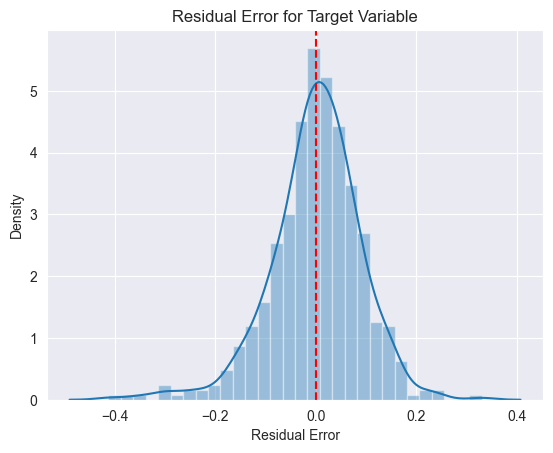

In [205]:
sns.set_style("darkgrid")
sns.distplot(res)
plt.title('Residual Error for Target Variable')
plt.axvline(x=res.mean(), color='r', linestyle='--', label='Max Probable Value')
plt.xlabel('Residual Error')  
plt.show()

- Residual Error Vs. Predicted Value Distribution for Normalized Rental Bikes Count:

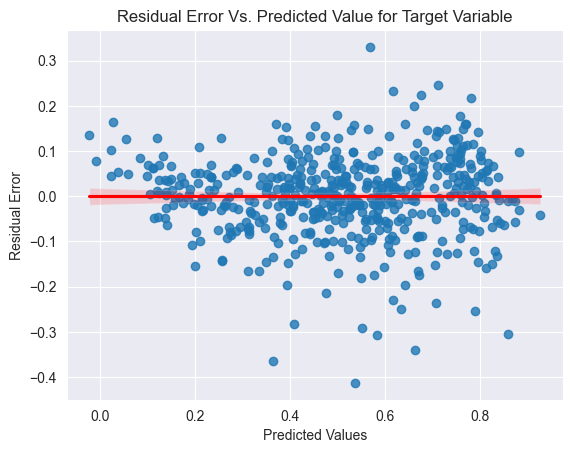

In [207]:
sns.set_style("darkgrid")
sns.regplot(x=y_train_pred, y=res, line_kws={'color': 'red'})
plt.title('Residual Error Vs. Predicted Value for Target Variable')
plt.xlabel('Predicted Values')
plt.ylabel('Residual Error')
plt.show()

**Normality:** Error terms are normally distributed with mean approximately at 0

**Independence of Residuals:** Total residual sum of error always lies at 0 level but the data points are scattered independently

**Homoscedasticity:** Error terms follow a constant variance in nature as the scattered data points are approximately linear in nature. The residual error terms always vary between -0.2 to +0.2 throughout the predicted values of target variable from 0 to 1. Few points which are out of this zone, indicate outliers or influential points.

 - Predicted Value Vs. Actual Value Distribution for Normalized Rental Bikes Count:

## Model Evaluation on Test Data

We have made use of Min-Max Scaling for training data and developed our linear regression model. So here we'll apply only the transform of testing data to convert into a Min-Max normalized data. Fitting shall not be done as it would try to use new statistics from testing data, which is not appropriate since the model hasn't seen this data during training.
Using transform on the test data ensures that the transformations are based solely on the training data, preventing any leakage of information that could bias the model's evaluation.

In [214]:
day_test[numerical_var] = scaler.transform(day_test[numerical_var])

In [215]:
day_test.describe().T

,count,mean,std,min,25%,50%,75%,max
yr,220.0,0.481818,0.500809,0.000000,0.000000,0.000000,1.000000,1.000000
holiday,220.0,0.036364,0.187620,0.000000,0.000000,0.000000,0.000000,1.000000
workingday,220.0,0.700000,0.459303,0.000000,0.000000,1.000000,1.000000,1.000000
temp,220.0,0.558718,0.233187,0.046591,0.355429,0.558172,0.755981,0.984424
atemp,220.0,0.532847,0.217401,0.025950,0.344870,0.544652,0.713308,0.980934
hum,220.0,0.638221,0.148694,0.261915,0.529197,0.625590,0.743798,1.002146
windspeed,220.0,0.313293,0.159584,-0.042808,0.198843,0.300126,0.402718,0.807474
cnt,220.0,0.522154,0.219163,0.048205,0.378595,0.524678,0.677750,0.963300
summerSeason,220.0,0.263636,0.441609,0.000000,0.000000,0.000000,1.000000,1.000000
fallSeason,220.0,0.245455,0.431338,0.000000,0.000000,0.000000,0.000000,1.000000


Initializing X and y variables for testing data:

In [217]:
y_test = day_test.pop('cnt')
X_test = day_test

#### Predicting the target variable of testing data using the Model developed:

Removing the feature variables which are not predictor variables of the final model developed, considering only the same attributes deduced for training data: 

In [220]:
X_test = X_test[X_train_rfe_final.columns]

Add constant to the testing data features which are the final selected predictor variables and predicting for testing data:

In [222]:
X_test = sm.add_constant(X_test)
y_test_pred = lr_model_final.predict(X_test)

#### R-squared for Training Data:

In [224]:
train_r2_score = r2_score(y_true=y_train, y_pred=y_train_pred)

In [225]:
print('R-squared of training dataset =', train_r2_score)

R-squared of training dataset = 0.8397521567311683


#### R-squared for Testing Data:

In [227]:
test_r2_score = r2_score(y_true=y_test, y_pred=y_test_pred)

In [228]:
print('R-squared of testing dataset =', test_r2_score)

R-squared of testing dataset = 0.7974599854948248


#### Error in R-squared between Training and Testing Data:

In [230]:
wt_avg_r2_score = np.average([train_r2_score, test_r2_score], weights = [0.7, 0.3])

In [231]:
error_r2_score = train_r2_score - test_r2_score

In [232]:
print('Absolute Error in R-squared between training and testing dataset =', round(error_r2_score,3))

Absolute Error in R-squared between training and testing dataset = 0.042


This absolute error in R-squared of training and testing data is less than 0.05, which indicates the model is a good fit for testing data as well

In [234]:
error_r2_percent = (error_r2_score/wt_avg_r2_score) * 100

In [235]:
print('Error percentage in R-squared between training and testing dataset =', round(error_r2_percent,3),'%')

Error percentage in R-squared between training and testing dataset = 5.114 %


This error percentage calulated for R-squared between training and testing data is less than 10% for which the model is in acceptable range for being a good fit for new data

## Linear Regression Model Expression:

#### Obtaining Co-efficients of the feature variables:

In [239]:
coefficients = (round(lr_model3.params,2)).sort_values(ascending = False)

In [240]:
coefficients

temp                0.52
yr                  0.23
winterSeason        0.14
sep                 0.11
summerSeason        0.10
const               0.09
sat                 0.06
workingday          0.05
aug                 0.05
holiday            -0.06
mistWeather        -0.08
windspeed          -0.15
lightRainWeather   -0.29
dtype: float64

#### Expression for Linear Regression Model developed:

In [242]:
def create_expression(coefficients):
    positive_variables = []
    negative_variables = []
    for variable, value in coefficients.items():
        if variable == 'const':
            continue  
        if value >= 0:
            positive_variables.append(f"{value} * {variable}")
        else:
            negative_variables.append(f"{-value} * {variable}")
    expression = " + ".join(positive_variables)
    if negative_variables:
        expression += " - " + " - ".join(negative_variables)
    return expression

In [243]:
expression = create_expression(coefficients)
print("cnt =", coefficients['const'], "+ " + expression)

cnt = 0.09 + 0.52 * temp + 0.23 * yr + 0.14 * winterSeason + 0.11 * sep + 0.1 * summerSeason + 0.06 * sat + 0.05 * workingday + 0.05 * aug - 0.06 * holiday - 0.08 * mistWeather - 0.15 * windspeed - 0.29 * lightRainWeather


Hence, the derived mathematical expression for the linear regression model developed is:

**cnt = 0.09 + 0.52 * temp + 0.23 * yr + 0.14 * winterSeason + 0.11 * sep + 0.1 * summerSeason + 0.06 * sat + 0.05 * workingday + 0.05 * aug - 0.06 * holiday - 0.08 * mistWeather - 0.15 * windspeed - 0.29 * lightRainWeather**

## Conclusion

#### Linear Regression Analysis:
 - 12 Predictor variables selected out of 30 variables to develop the best version of Linear regression model
 - R-squared of training dataset = 0.840
 - R-squared of testing dataset = 0.797
 - Mathematical Expression of model: cnt = 0.09 + 0.52 * temp + 0.23 * yr + 0.14 * winterSeason + 0.11 * sep + 0.1 * summerSeason + 0.06 * sat + 0.05 * workingday + 0.05 * aug - 0.06 * holiday - 0.08 * mistWeather - 0.15 * windspeed - 0.29 * lightRainWeather

#### Perception from given data after analysis:
 - The required count of rental bikes is highly dependent on Temperature. Higher temperature in the area offers a profitable business to that segment.
 - The business is not favorable during Rainy weather as people don't prefer 2 wheeler due to wet conditions.
 - The demand for bikes has increased from 2018 to 2019 indicating a good turnover for the company.
 - Heavy and Strong winds lead to decrease in demand for bikes due to diffculty in driving during high wind speed.
 - The company is doing well in Summer and Winter season and in between August - September period.
 - Misty weather is also unfavorable for the business.
 - The demand goes down during public holidays and is considerably good during working days.